### Import Libraries

In [16]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (make_scorer, precision_score, recall_score, f1_score, roc_auc_score, classification_report, accuracy_score)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os

In [17]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [18]:
def aggregate_classes(score):
    """Define score ranges for classification."""
    if score < 55:
        return "Below 55"
    elif score <= 60:
        return "55-60"
    elif score <= 65:
        return "61-65"
    elif score <= 70:
        return "66-70"
    elif score <= 75:
        return "71-75"
    elif score <= 80:
        return "76-80"
    else:
        return "81+"

In [19]:
def plot_distribution(distribution, title):
    """Plot class distribution."""
    plt.figure(figsize=(10, 6))
    plt.bar(distribution.index, distribution.values)
    plt.title(title)
    plt.xlabel('Score Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [20]:
def print_distribution(distribution, description):
    """Print class distribution with percentages."""
    print(f"\nClass Distribution {description}:")
    total = distribution.sum()
    for class_label, count in distribution.items():
        percentage = (count / total) * 100
        print(f"{class_label}: {count} samples ({percentage:.2f}%)")

### Load Dataset and Preprocess

In [21]:
df = pd.read_csv("student_performance/StudentPerformanceFactorsAdjusted.csv")

In [22]:
# Handle categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include='object').columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [23]:
# Prepare features and target
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score'].map(aggregate_classes)

In [24]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### Analyze Initial Class Distribution


Class Distribution Before SMOTE:
55-60: 145 samples (2.19%)
61-65: 1986 samples (30.06%)
66-70: 3393 samples (51.35%)
71-75: 1007 samples (15.24%)
76-80: 33 samples (0.50%)
81+: 43 samples (0.65%)


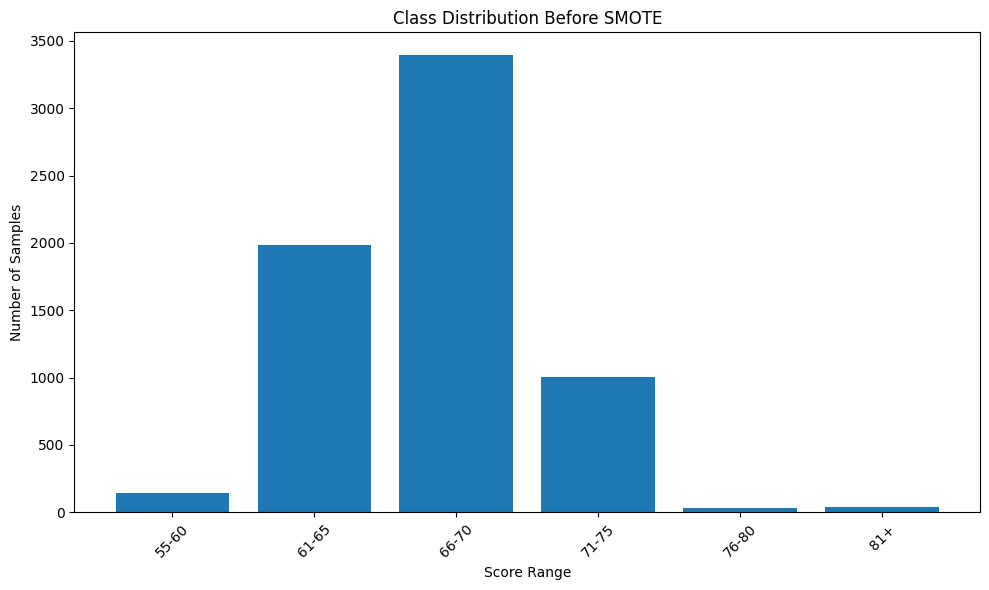

In [25]:
initial_distribution = y.value_counts().sort_index()
print_distribution(initial_distribution, "Before SMOTE")
plot_distribution(initial_distribution, 'Class Distribution Before SMOTE')

### Initial Model Training

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

initial_rf = RandomForestClassifier(random_state=42)
initial_rf.fit(X_train, y_train)
y_pred_initial = initial_rf.predict(X_test)

print("\nInitial Model Performance:")
print(classification_report(y_test, y_pred_initial))
print(f"Initial Test Set Accuracy: {accuracy_score(y_test, y_pred_initial):.4f}")



Initial Model Performance:
              precision    recall  f1-score   support

       55-60       1.00      0.17      0.29        24
       61-65       0.84      0.80      0.82       399
       66-70       0.78      0.92      0.84       667
       71-75       0.89      0.57      0.70       223
       76-80       0.00      0.00      0.00         3
         81+       0.00      0.00      0.00         6

    accuracy                           0.81      1322
   macro avg       0.58      0.41      0.44      1322
weighted avg       0.81      0.81      0.79      1322

Initial Test Set Accuracy: 0.8064


### Apply SMOTE and Analyze Balanced Distribution

In [27]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)



Class Distribution After SMOTE:
55-60: 3393 samples (16.67%)
61-65: 3393 samples (16.67%)
66-70: 3393 samples (16.67%)
71-75: 3393 samples (16.67%)
76-80: 3393 samples (16.67%)
81+: 3393 samples (16.67%)


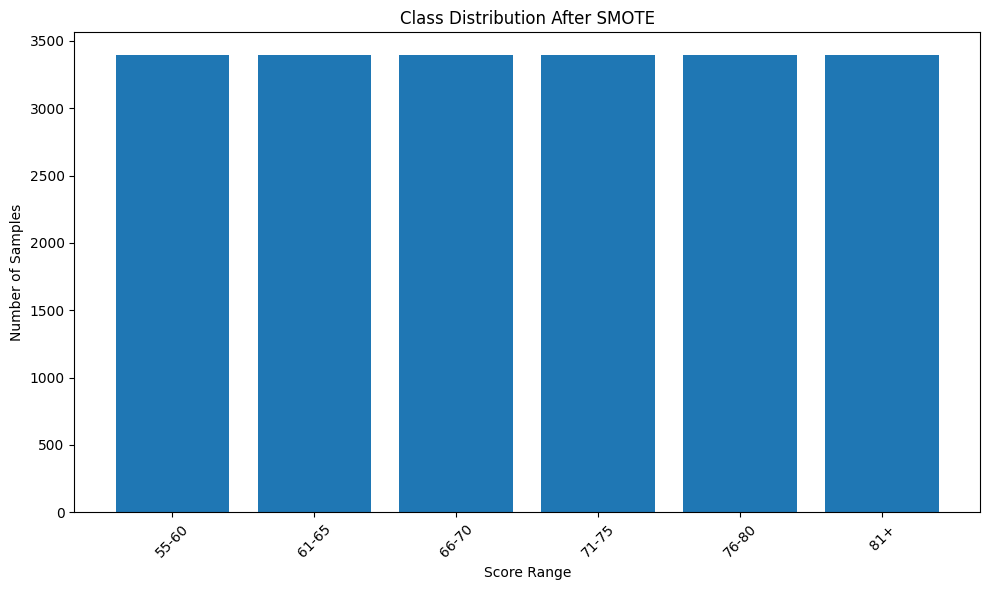

In [28]:
# Analyze balanced distribution
balanced_distribution = pd.Series(y_balanced).value_counts().sort_index()
print_distribution(balanced_distribution, "After SMOTE")
plot_distribution(balanced_distribution, 'Class Distribution After SMOTE')


### Hyperparameter Tuning

In [29]:
# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [30]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [31]:
# Perform GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=4
)

In [32]:
grid_search.fit(X_train, y_train)
print(f"\nBest parameters: {grid_search.best_params_}")


Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Final Model Evaluation

In [33]:
best_rf = grid_search.best_estimator_
y_pred_final = best_rf.predict(X_test)

print("\nFinal Model Performance (After SMOTE and Tuning):")
print(classification_report(y_test, y_pred_final))
print(f"Final Test Set Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")


Final Model Performance (After SMOTE and Tuning):
              precision    recall  f1-score   support

       55-60       0.99      1.00      0.99       656
       61-65       0.94      0.90      0.92       733
       66-70       0.85      0.89      0.87       635
       71-75       0.96      0.95      0.95       664
       76-80       1.00      1.00      1.00       715
         81+       1.00      1.00      1.00       669

    accuracy                           0.96      4072
   macro avg       0.96      0.96      0.96      4072
weighted avg       0.96      0.96      0.96      4072

Final Test Set Accuracy: 0.9568


### Feature Importance Visualization

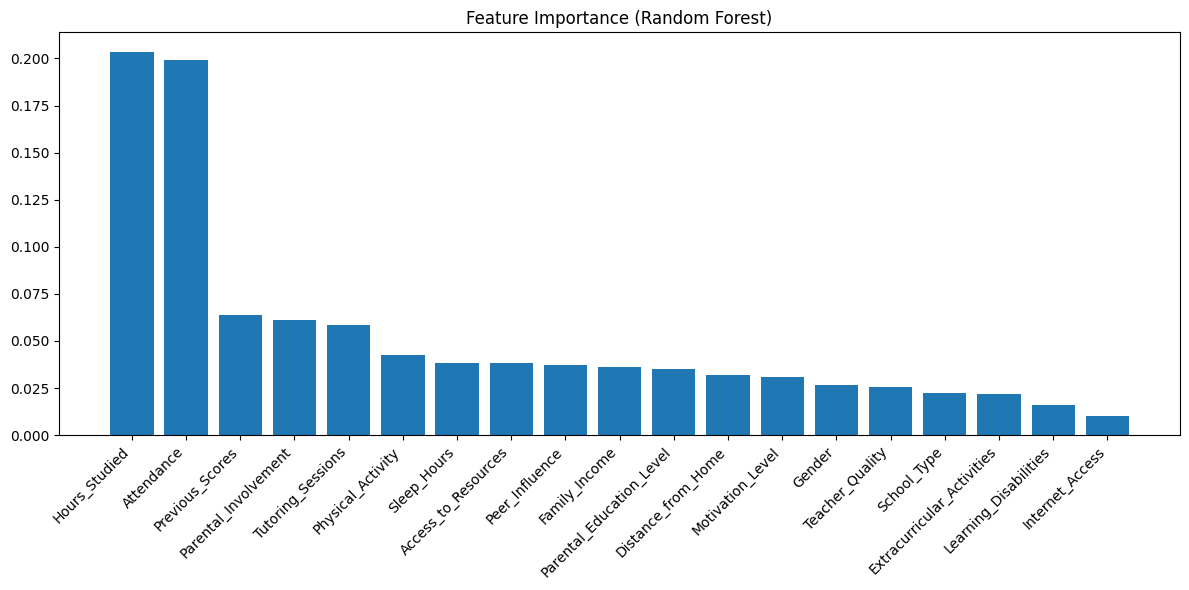

In [34]:
plt.figure(figsize=(12, 6))
plt.title('Feature Importance (Random Forest)')
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), 
           [X.columns[i] for i in indices], 
           rotation=45, 
           ha='right')
plt.tight_layout()
plt.show()